In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
path = '/Users/blandt/Desktop/Data/PAR2 GFP mutants 2/Experiment'
paths = direcslist(path, 1)

imgs = [load_image(glob.glob(p + '/af_corrected.tif')[0]) for p in paths]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]

In [3]:
cytbg = np.loadtxt('../T2A/cytbg.txt')
membg = np.loadtxt('../PAR2 RING MUTANTS/mem_profile.txt')

In [4]:
iq = ImageQuant(img=imgs, roi=rois, descent_steps=350, rol_ave=5, 
                lr=0.01, iterations=1, cytbg=cytbg, membg=membg, uni_cyt=True, interp_type='linear')
iq.run()

100%|██████████| 350/350 [00:54<00:00,  6.47it/s]


Time elapsed: 55.80 seconds 


<IPython.core.display.Javascript object>


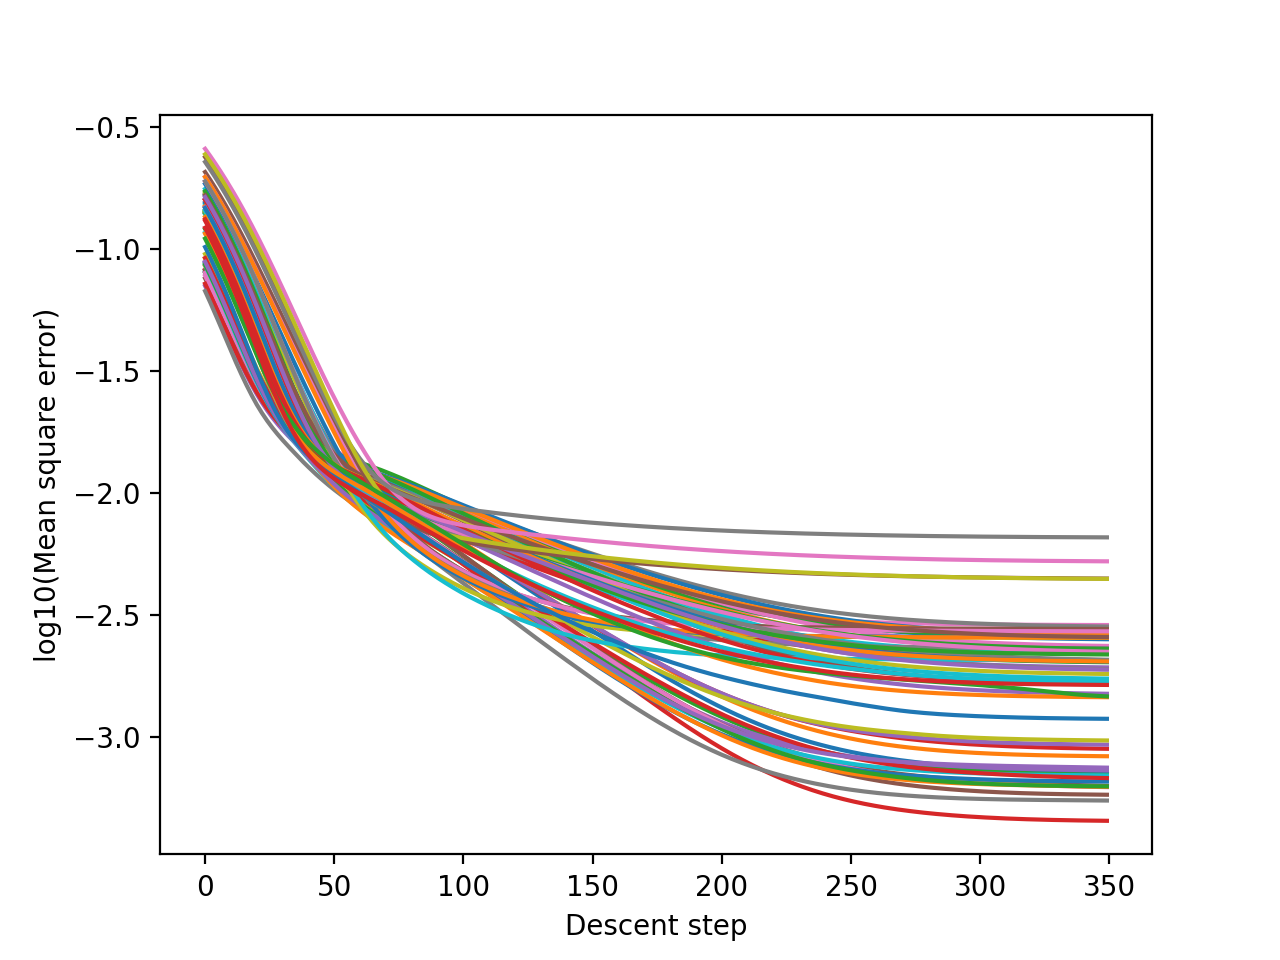

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [5]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


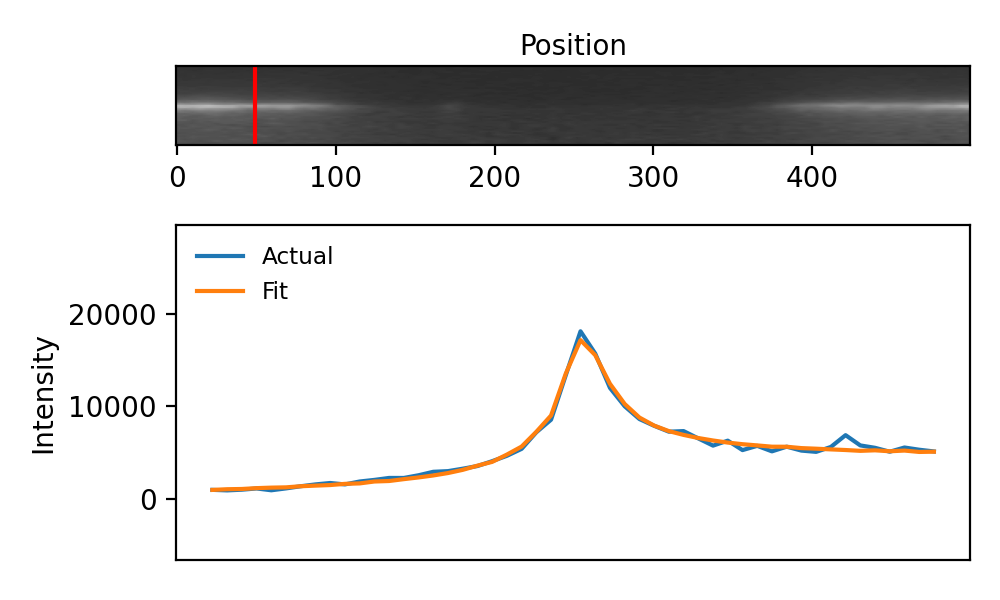

interactive(children=(IntSlider(value=0, description='Frame', max=63), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [6]:
iq.plot_fits(jupyter=True)

<IPython.core.display.Javascript object>


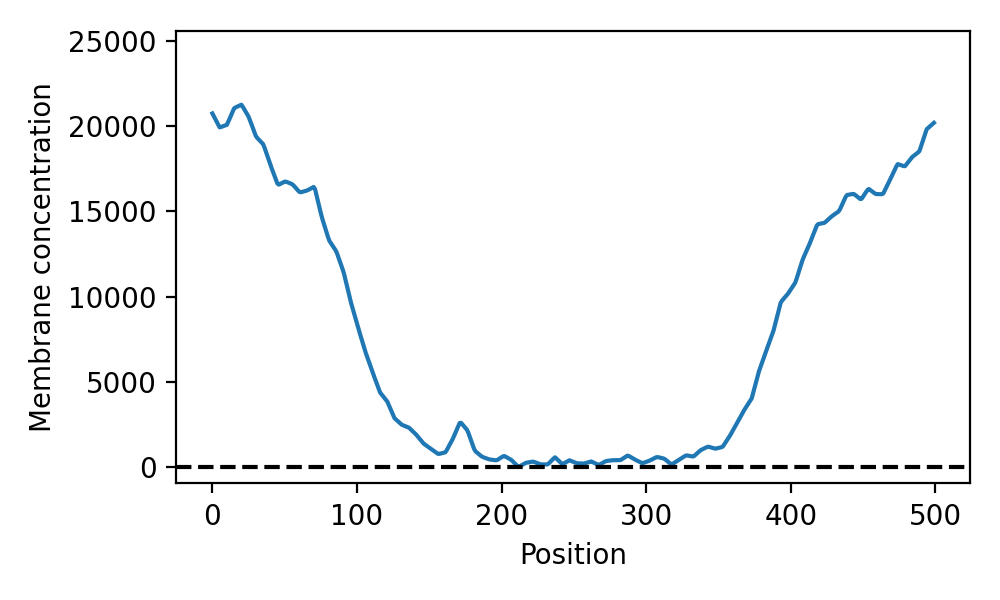

interactive(children=(IntSlider(value=0, description='Frame', max=63), Output()), _dom_classes=('widget-intera…

(<Figure size 500x300 with 1 Axes>,
 <AxesSubplot:xlabel='Position', ylabel='Membrane concentration'>)

In [7]:
iq.plot_quantification(jupyter=True)

In [8]:
print(paths[28])

/Users/blandt/Desktop/Data/PAR2 GFP mutants 2/Experiment/220129_nwg192_tom4,15,60/00


### Compile results

In [9]:
res = iq.compile_res()
res.to_csv('res.csv')

In [10]:
res = pd.read_csv('res.csv')

lines = [p.strip('/').split('/')[-2].split('_')[1] for p in paths]

genotype_dict = {'nwg190': 'R163A', 'nwg178': 'AxA', 'kk1273': 'WT', 'nwg214': 'C56S', 'nwg66': 'AxA', 
                 'nwg217': 'R183-5A', 'nwg222': 'C56S', 'nwg218': 'R163A', 'nwg192': 'R183-5A', 'nwg123': 'WT'}
condition_dict = {'nwg190': 'Pol', 'nwg178': 'Uni', 'kk1273': 'Pol', 'nwg214': 'Pol', 'nwg66': 'Pol', 
                  'nwg217': 'Uni', 'nwg222': 'Uni', 'nwg218': 'Uni', 'nwg192': 'Pol', 'nwg123': 'Uni'}
genotypes = [genotype_dict[l] for l in lines]
conditions = [condition_dict[l] for l in lines]

mems_tot = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0, 1))) * 2.8893596260583494
mems_ant = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.4, 0.6))) * 2.8893596260583494
mems_post = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.9, 0.1))) * 2.8893596260583494
cyts = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], (0, 1)))
ratios_tot = [m / c for m, c in zip(mems_tot, cyts)]
ratios_post = [m / c for m, c in zip(mems_post, cyts)]
ratios_ant = [m / c for m, c in zip(mems_ant, cyts)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
tots = [c + 0.174 * m for c, m in zip(cyts, mems_tot)]

df_dict = {'Path': paths, 'Line': lines, 'Mem tot': mems_tot, 'Mem ant': mems_ant, 'Mem post': mems_post,
           'Cyt': cyts, 'Dosage': dosages, 'Ratio tot': ratios_tot, 'Ratio post': ratios_post, 'Ratio ant': ratios_ant,
          'Genotype': genotypes, 'Condition': conditions, 'Total': tots}
df = pd.DataFrame(df_dict)
df.to_csv('df.csv')